In [1]:
from RegionDeConfianza import dogleg_debug_exacto, dogleg_exacto
import numpy as np

In [2]:
def best_alpha_golden_search(f, x, p, a_0=0, b_0=1, tol=1e-5):
    """
    Perform a golden-section search to find the optimal step size along the search direction.
    f: Objective function
    x: Current position
    p: Search direction
    a_0, b_0: Initial bounds for alpha
    tol: Tolerance for convergence
    """
    golden = (np.sqrt(5) - 1) / 2
    a_k = a_0
    b_k = b_0
    
    while (b_k - a_k) > tol:
        c_k = b_k - golden * (b_k - a_k)
        d_k = a_k + golden * (b_k - a_k)
        
        # Evaluate the function at the test points
        if f(x + c_k * p) < f(x + d_k * p):
            b_k = d_k
        else:
            a_k = c_k
    
    # Return the midpoint of the final interval
    return (a_k + b_k) / 2

def steepest_descent(f, gradf, x0, tol=1e-5, maxiter=100):
    """
    Perform steepest descent optimization.
    f: Objective function
    gradf: Gradient of the objective function
    x0: Initial guess
    tol: Tolerance for gradient norm
    maxiter: Maximum number of iterations
    """
    x = x0
    iters = 0
    convergence = False
    
    while iters < maxiter:
        iters += 1
        
        # Compute search direction (negative gradient)
        p = -gradf(x)
        
        # Find the optimal step size using golden-section search
        alpha = best_alpha_golden_search(f, x, p)
        
        # Update the position
        x = x + alpha * p
        
        # Check convergence
        if np.linalg.norm(gradf(x)) < tol:
            convergence = True
            break
    return x , iters, convergence

def steepest_descent_graph(f, gradf, x0, tol=1e-5, maxiter=100):
    """
    Perform steepest descent optimization with trajectory tracking.
    f: Objective function
    gradf: Gradient of the objective function
    x0: Initial guess
    tol: Tolerance for gradient norm
    maxiter: Maximum number of iterations
    Returns:
        x: Optimal point
        iters: Number of iterations
        convergence: Whether the algorithm converged
        x_k: List of points visited during optimization
        f_k: List of function values at each point
    """
    x = x0
    iters = 0
    convergence = False
    x_k = [x.copy()]
    f_k = [f(x)]
    alphas = [1]
    
    while iters < maxiter:
        iters += 1
        
        # Compute search direction (negative gradient)
        p = -gradf(x)
        
        # Find the optimal step size using golden-section search
        alpha = best_alpha_golden_search(f, x, p)
        
        # Update the position
        x = x + alpha * p
        
        # Track trajectory
        x_k.append(x.copy())
        f_k.append(f(x))
        alphas.append(alpha)
        
        # Check convergence
        if np.linalg.norm(gradf(x)) < tol:
            convergence = True
            break

    return x, iters, convergence, x_k, f_k



def steepestv2(f, gradf, x0, tol=1e-5, maxiter=100, alpha=1.0):
    """
    Steepest descent with a fixed step size.
    f: Objective function
    gradf: Gradient of the objective function
    x0: Initial guess
    tol: Tolerance for gradient norm
    maxiter: Maximum number of iterations
    alpha: Fixed step size
    """
    x = x0
    iters = 0
    convergence = False
    
    while iters < maxiter:
        iters += 1
        
        # Compute the search direction (negative gradient)
        p = -gradf(x)
        
        # Update the position
        x_new = x + alpha * p
        
        # Check if the step reduces the function value
        if f(x_new) >= f(x):
            # If not, reduce the step size
            alpha *= 0.5
        else:
            x = x_new
        
        # Check for convergence
        if np.linalg.norm(gradf(x)) < tol:
            convergence = True
            break
    
    return x, iters, convergence



In [3]:
def rosenbrock(x): 
    return 100*(x[1] - x[0]**2)**2 + (1 - x[0])**2

def rosenbrock_grad(x):
    return np.array([400*x[0]**3 - 400*x[0]*x[1]+2*x[0]-2, 200*(x[1] - x[0]**2)])

def rosenbrock_hess(x):
    return np.array([[1200*x[0]**2 - 400*x[1] + 2, -400*x[0]], [-400*x[0], 200]])

In [4]:
x0 = np.array([-1.2, 1.0])  
delta0 = 0.5  
max_delta = 2.0  
eta = 0.1 
max_iter = 100
tol = 1e-6

In [5]:
X_dogleg, f_X = dogleg_exacto(rosenbrock, rosenbrock_grad, rosenbrock_hess, x0, delta0, max_delta, eta, max_iter,tol)
X_dogleg

array([1., 1.])

In [6]:
results = dogleg_debug_exacto(rosenbrock, rosenbrock_grad, rosenbrock_hess, x0, delta0, max_delta, eta, max_iter,tol)
results[-1]

27

In [7]:
X_steepest = steepest_descent(rosenbrock, rosenbrock_grad, x0, tol, 2000)
X_steepest

(array([1.0000011, 1.0000022]), 1604, True)

In [8]:
print(X_steepest)

(array([1.0000011, 1.0000022]), 1604, True)


In [9]:
X_steepestv2 = steepestv2(rosenbrock, rosenbrock_grad, x0, tol, 35000)
X_steepestv2

(array([0.99999888, 0.99999776]), 32857, True)

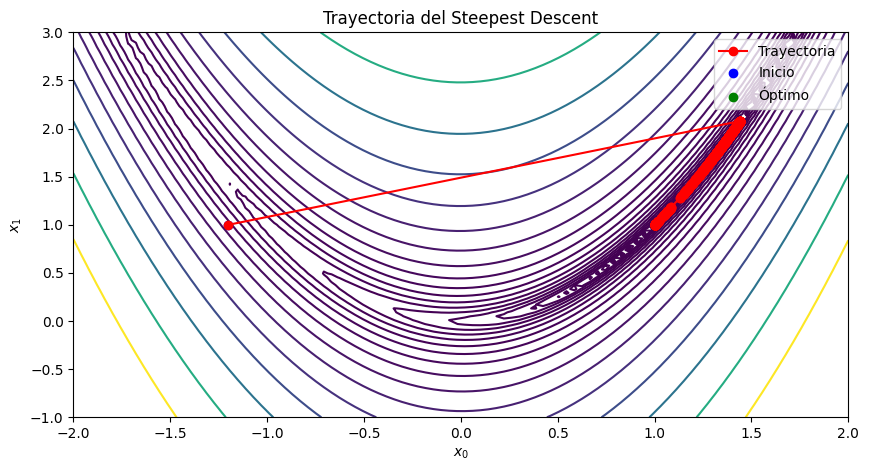

In [10]:
import numpy as np
import matplotlib.pyplot as plt


# Define the grid for the contour plot
X, Y = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-1, 3, 100))
Z = 100 * (Y - X**2)**2 + (1 - X)**2

# Run steepest descent with trajectory tracking
x_opt, iters, convergence, x_k, f_k = steepest_descent_graph(rosenbrock, rosenbrock_grad, x0, tol=1e-5, maxiter=2000)

# Plot the results
fig = plt.figure(figsize=(10, 5))

# Contour plot
plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap="viridis")
x_k = np.array(x_k)  # Convert trajectory to array for plotting
plt.plot(x_k[:, 0], x_k[:, 1], 'r-o', label="Trayectoria")
plt.scatter(x0[0], x0[1], color="blue", label="Inicio")
plt.scatter(x_opt[0], x_opt[1], color="green", label="Óptimo")
plt.title("Trayectoria del Steepest Descent")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend()

plt.show()
